In [1]:
%matplotlib widget

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import statsmodels.api as sm
from matplotlib import cm
import matplotlib as mpl

plt.style.use("presentation.mplstyle")

In [2]:
path_root = r"/scratch-shared/amftrack/transport/csv_new/"

paths = [path for path in os.listdir(path_root) if path.split(".")[-1] == "csv"]
table = pd.DataFrame()
for path in paths:
    table = pd.concat([table, pd.read_csv(os.path.join(path_root, path))])
table["days"] = table["time_since_crossing"] / pd.Timedelta(days=1)
table["3days"] = (table["time_since_crossing"] / pd.Timedelta(days=3)).astype(int)
table["days_since_first_image"] = table["days"] - table.groupby("unique_id")[
    "days"
].transform("min")
table["abs_speed-"] = -table["speed-"]

table["speed"] = table[["speed+", "abs_speed-"]].max(1)
table["lengthdm"] = (np.log2((table["tot_length"])) / 2).astype(int) * 2
table["log_tot_num_spores"] = (np.log10((table["tot_num_spore"]))).astype(int)
# table['normalized_random_betweenness'] = (table['random_betweenness']-table['min_random_betweenness'])/(table['max_random_betweenness']-table['min_random_betweenness'])
# table['normalized_betweenness'] = (table['betweenness']-table['min_betweenness'])/(table['max_betweenness']-table['min_betweenness'])

In [3]:
path_root = r"/scratch-shared/amftrack/transport/csv_spores/"

paths = [path for path in os.listdir(path_root) if path.split(".")[-1] == "csv"]
table_spores = pd.DataFrame()
for path in paths:
    table_spores = pd.concat([table_spores, pd.read_csv(os.path.join(path_root, path))])
table_spores["days"] = table_spores["time_since_crossing"] / pd.Timedelta(days=1)
table_spores["3days"] = (
    table_spores["time_since_crossing"] / pd.Timedelta(days=3)
).astype(int)

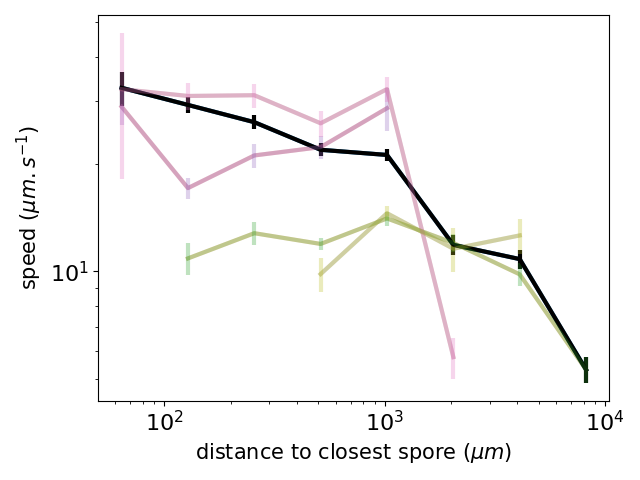

In [4]:
fig, ax = plt.subplots()
select = table.loc[table["spore_distance"] >= 0].copy()
select = select.loc[select["tot_num_spore"] >= 10].copy()
select["spore_distance_log"] = (np.log2((select["spore_distance"]))).astype(int)
select = select.loc[select["speed+"].between(1, 50)]
select = select.loc[select["speed-"].between(-50, -1)]
# ax.scatter(select['days'],select['speed'],alpha =0.1)
mean = select.groupby("spore_distance_log")["speed"].quantile(0.9)
std = select.groupby("spore_distance_log")["speed"].std()
count = select.groupby("spore_distance_log")["speed"].count()
ax.plot(2**mean.index, mean)
ax.errorbar(2**mean.index, mean, std / np.sqrt(count), color="black")
for unique_id in select["unique_id"].unique():
    sub_select = select.loc[select["unique_id"] == unique_id]
    mean = sub_select.groupby("spore_distance_log")["speed"].quantile(0.9)
    std = sub_select.groupby("spore_distance_log")["speed"].std()
    count = sub_select.groupby("spore_distance_log")["speed"].count()
    ax.plot(2**mean.index, mean, alpha=0.3)
    ax.errorbar(2**mean.index, mean, std / np.sqrt(count), alpha=0.3)
ax.set_xlabel("distance to closest spore ($\mu m$)")
ax.set_ylabel("speed ($\mu m.s^{-1}$)")
# ax.set_ylim(0,20)
ax.set_yscale("log")
ax.set_xscale("log")


plt.tight_layout()

In [22]:
select_unique = table.loc[table["unique_id"] == "40_20201214"]
select_unique["random_betweenness"]

0     0.000073
1     0.000110
2     0.000110
3     0.001670
4     0.001670
5     0.001225
6     0.001225
7     0.001225
8     0.000683
9     0.000683
10    0.001670
11    0.001670
12    0.001670
13    0.000018
14    0.000018
15    0.000018
16    0.000018
17    0.000018
18    0.000018
19    0.001787
20    0.001787
21    0.001787
22    0.000731
23    0.000731
24    0.000731
25    0.000196
26    0.000196
27    0.000018
28    0.000018
29    0.001735
30    0.001949
31    0.001949
32    0.000073
33    0.000452
34    0.000452
35    0.001233
36    0.001233
37    0.001233
38    0.001233
39    0.003595
40    0.003595
41    0.003344
42    0.003344
43    0.003344
44    0.003344
45    0.000640
46    0.000640
47    0.001483
48    0.001483
49    0.004114
50    0.004114
51    0.004074
52    0.004074
53    0.001132
54    0.001132
Name: random_betweenness, dtype: float64

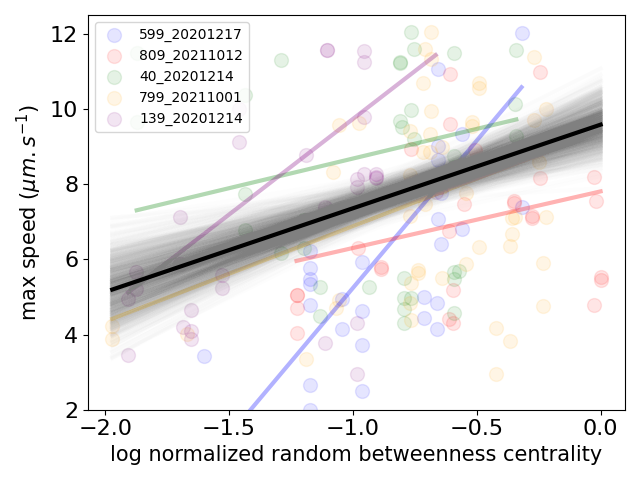

In [5]:
plt.close("all")
fig, ax = plt.subplots()
select = table.loc[table["normalized_random_betweenness"] > 0.01]
colors = ["blue", "red", "green", "orange", "purple", "grey", "pink", "cyan"]
# for i,unique_id in enumerate(select['unique_id'].unique()):
selection = [
    "599_20201217",
    "809_20211012",
    "40_20201214",
    "799_20211001",
    "139_20201214",
]
ydata = "normalized_random_betweenness"
for i, unique_id in enumerate(selection):

    select_unique = select.loc[select["unique_id"] == unique_id]
    select_unique = select_unique.sort_values(ydata)

    x, y = select_unique[ydata], select_unique["speed"]

    x = np.log10(x)
    ax.scatter(x, y, label=unique_id, color=colors[i], alpha=0.1)
    # ax.set_xscale('log')
    X = sm.add_constant(x, prepend=False)
    model = sm.OLS(y, X)
    res = model.fit()
    a, b = res.params[0], res.params[1]
    ax.plot(x, np.array(x) * a + b, color=colors[i], alpha=0.3)
select_unique = select.loc[select["unique_id"].isin(selection)].copy()
select_unique = select_unique.sort_values(ydata)

x, y = select_unique[ydata], select_unique["speed"]

x = np.log10(x)
x0 = np.linspace(np.min(x), np.max(x), 10)


def statistic(x, y):
    X = sm.add_constant(x, prepend=False)
    model = sm.OLS(y, X)
    res = model.fit()
    a, b = res.params[0], res.params[1]
    ax.plot(x0, np.array(x0) * a + b, color="grey", alpha=0.01)
    return a


data = np.array((x, y))
n_resamples = 1000
std = scipy.stats.bootstrap(
    data,
    statistic,
    vectorized=False,
    method="basic",
    n_resamples=n_resamples,
    paired=True,
).standard_error
X = sm.add_constant(x, prepend=False)
model = sm.OLS(y, X)
res = model.fit()
a, b = res.params[0], res.params[1]
ax.plot(x, np.array(x) * a + b, color="black")

ax.legend()
ax.set_ylim(2, 12.5)
# ax.set_xscale('log')

ax.set_xlabel("log normalized random betweenness centrality")
ax.set_ylabel("max speed ($\mu m.s^{-1}$)")
plt.tight_layout()

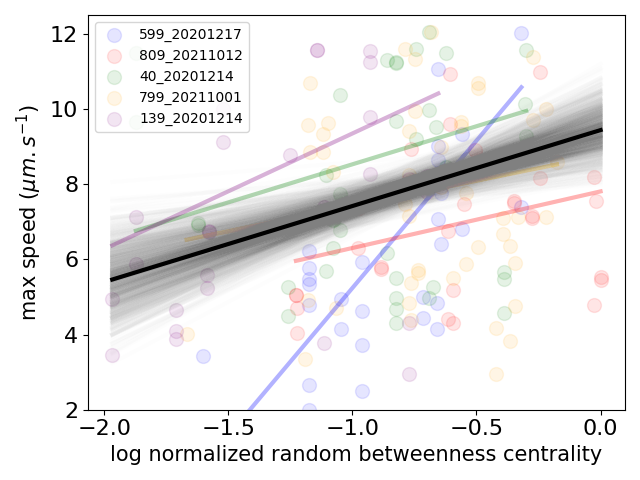

In [4]:
plt.close("all")
fig, ax = plt.subplots()
select = table.loc[table["normalized_random_betweenness"] > 0.01]
colors = ["blue", "red", "green", "orange", "purple", "grey", "pink", "cyan"]
# for i,unique_id in enumerate(select['unique_id'].unique()):
selection = [
    "599_20201217",
    "809_20211012",
    "40_20201214",
    "799_20211001",
    "139_20201214",
]
ydata = "normalized_random_betweenness"
for i, unique_id in enumerate(selection):

    select_unique = select.loc[select["unique_id"] == unique_id]
    select_unique = select_unique.sort_values(ydata)

    x, y = select_unique[ydata], select_unique["speed"]

    x = np.log10(x)
    ax.scatter(x, y, label=unique_id, color=colors[i], alpha=0.1)
    # ax.set_xscale('log')
    X = sm.add_constant(x, prepend=False)
    model = sm.OLS(y, X)
    res = model.fit()
    a, b = res.params[0], res.params[1]
    ax.plot(x, np.array(x) * a + b, color=colors[i], alpha=0.3)
select_unique = select.loc[select["unique_id"].isin(selection)].copy()
select_unique = select_unique.sort_values(ydata)

x, y = select_unique[ydata], select_unique["speed"]

x = np.log10(x)
x0 = np.linspace(np.min(x), np.max(x), 10)


def statistic(x, y):
    X = sm.add_constant(x, prepend=False)
    model = sm.OLS(y, X)
    res = model.fit()
    a, b = res.params[0], res.params[1]
    ax.plot(x0, np.array(x0) * a + b, color="grey", alpha=0.01)
    return a


data = np.array((x, y))
n_resamples = 1000
std = scipy.stats.bootstrap(
    data,
    statistic,
    vectorized=False,
    method="basic",
    n_resamples=n_resamples,
    paired=True,
).standard_error
X = sm.add_constant(x, prepend=False)
model = sm.OLS(y, X)
res = model.fit()
a, b = res.params[0], res.params[1]
ax.plot(x, np.array(x) * a + b, color="black")

ax.legend()
ax.set_ylim(2, 12.5)
# ax.set_xscale('log')

ax.set_xlabel("log normalized random betweenness centrality")
ax.set_ylabel("max speed ($\mu m.s^{-1}$)")
plt.tight_layout()

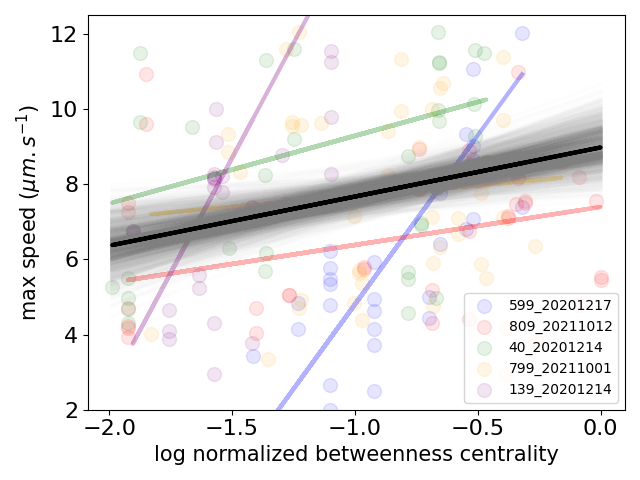

In [72]:
plt.close("all")
fig, ax = plt.subplots()
select = table.loc[table["normalized_betweenness"] > 0.01]
colors = ["blue", "red", "green", "orange", "purple", "grey", "pink", "cyan"]
# for i,unique_id in enumerate(select['unique_id'].unique()):

ydata = "normalized_betweenness"
for i, unique_id in enumerate(selection):

    select_unique = select.loc[select["unique_id"] == unique_id]
    x, y = select_unique[ydata], select_unique["speed"]

    x = np.log10(x)
    ax.scatter(x, y, label=unique_id, color=colors[i], alpha=0.1)
    # ax.set_xscale('log')
    X = sm.add_constant(x, prepend=False)
    model = sm.OLS(y, X)
    res = model.fit()
    a, b = res.params[0], res.params[1]
    ax.plot(x, np.array(x) * a + b, color=colors[i], alpha=0.3)
select_unique = select.loc[select["unique_id"].isin(selection)].copy()
x, y = select_unique[ydata], select_unique["speed"]

x = np.log10(x)
# ax.set_xscale('log')
x0 = np.linspace(np.min(x), np.max(x), 10)


def statistic(x, y):
    X = sm.add_constant(x, prepend=False)
    model = sm.OLS(y, X)
    res = model.fit()
    a, b = res.params[0], res.params[1]
    ax.plot(x0, np.array(x0) * a + b, color="grey", alpha=0.01)
    return a


data = np.array((x, y))
n_resamples = 1000
std = scipy.stats.bootstrap(
    data,
    statistic,
    vectorized=False,
    method="basic",
    n_resamples=n_resamples,
    paired=True,
).standard_error
X = sm.add_constant(x, prepend=False)
model = sm.OLS(y, X)
res = model.fit()
a, b = res.params[0], res.params[1]
ax.plot(x, np.array(x) * a + b, color="black")

ax.legend()
ax.set_ylim(2, 12.5)

ax.set_xlabel("log normalized betweenness centrality")
ax.set_ylabel("max speed ($\mu m.s^{-1}$)")
plt.tight_layout()

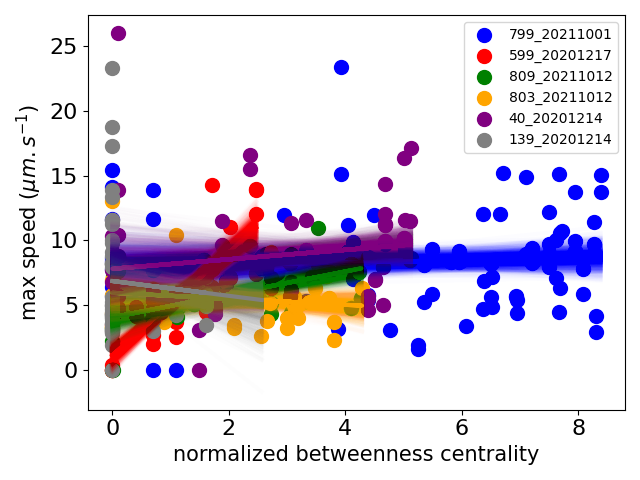

In [32]:
plt.close("all")
fig, ax = plt.subplots()
select = table.loc[table["betweenness"] > 1e-8]
# colors = ['blue','red','green','orange']
for i, unique_id in enumerate(select["unique_id"].unique()):
    select_unique = select.loc[select["unique_id"] == unique_id]
    x, y = (
        select_unique["betweenness"] / np.min(select_unique["betweenness"]),
        select_unique["speed"],
    )
    x = np.log(x)
    ax.scatter(x, y, label=unique_id, color=colors[i])
    # ax.set_xscale('log')
    x0 = np.linspace(np.min(x), np.max(x), 10)

    def statistic(x, y):
        X = sm.add_constant(x, prepend=False)
        model = sm.OLS(y, X)
        res = model.fit()
        a, b = res.params[0], res.params[1]
        ax.plot(x0, np.array(x0) * a + b, color=colors[i], alpha=0.01)
        return a

    data = np.array((x, y))
    n_resamples = 1000
    std = scipy.stats.bootstrap(
        data,
        statistic,
        vectorized=False,
        method="basic",
        n_resamples=n_resamples,
        paired=True,
    ).standard_error
    X = sm.add_constant(x, prepend=False)
    model = sm.OLS(y, X)
    res = model.fit()
    a, b = res.params[0], res.params[1]
    ax.plot(x, np.array(x) * a + b, color=colors[i])
ax.legend()
ax.set_xlabel("normalized betweenness centrality")
ax.set_ylabel("max speed ($\mu m.s^{-1}$)")
plt.tight_layout()

In [6]:
select["unique_id"].unique()

array(['599_20201217', '809_20211012', '799_20211001', '803_20211012'],
      dtype=object)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


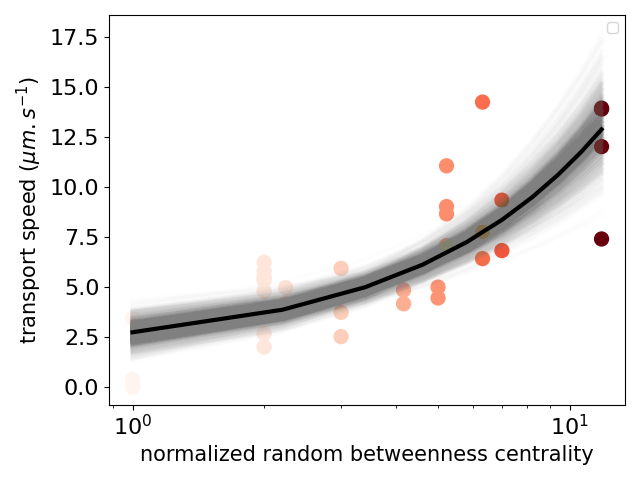

In [15]:
plt.close("all")
fig, ax = plt.subplots()
select = table.loc[table["random_betweenness"] > 1e-8]
colors = ["blue", "red", "green", "orange"]

select_unique = select.loc[select["unique_id"] == "599_20201217"]
select_unique = select_unique.sort_values("random_betweenness")
x, y = (
    select_unique["random_betweenness"] / np.min(select_unique["random_betweenness"]),
    select_unique["speed"],
)
# x = np.log(x)
ax.scatter(x, y, c=x, cmap="Reds")
ax.set_xscale("log")
x0 = np.linspace(np.min(x), np.max(x), 10)


def statistic(x, y):
    X = sm.add_constant(x, prepend=False)
    model = sm.OLS(y, X)
    res = model.fit()
    a, b = res.params[0], res.params[1]
    ax.plot(x0, np.array(x0) * a + b, color="grey", alpha=0.01)
    return a


data = np.array((x, y))
n_resamples = 1000
std = scipy.stats.bootstrap(
    data,
    statistic,
    vectorized=False,
    method="basic",
    n_resamples=n_resamples,
    paired=True,
).standard_error
X = sm.add_constant(x, prepend=False)
model = sm.OLS(y, X)
res = model.fit()
a, b = res.params[0], res.params[1]
ax.plot(x0, np.array(x0) * a + b, color="black")
ax.legend()
ax.set_xlabel("normalized random betweenness centrality")
ax.set_ylabel("transport speed ($\mu m.s^{-1}$)")
plt.tight_layout()

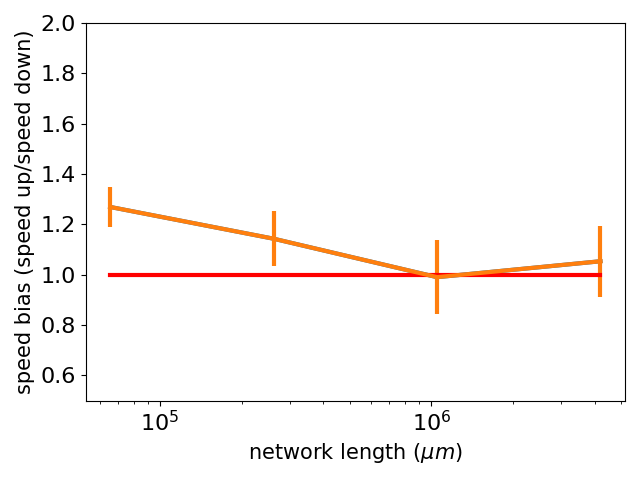

In [24]:
fig, ax = plt.subplots()
table["bias"] = -table["speed+"] / table["speed-"]
table["bias"] = table["bias"].replace(np.inf, 1)
table["bias"] = table["bias"].replace(-np.inf, 1)
select = table.loc[table["bias"] < 5]
# ax.scatter(select['3days'],select['bias'],alpha =0.1)
ax.set_ylim(0.5, 2)
mean = select.groupby("lengthdm")["bias"].median()
std = select.groupby("lengthdm")["bias"].std()
count = select.groupby("lengthdm")["bias"].count()
ax.plot(2**mean.index, mean)
ax.errorbar(2**mean.index, mean, 2 * std / np.sqrt(count))
ax.set_xlabel("network length ($\mu m$)")
ax.set_ylabel("speed bias (speed up/speed down)")
ax.plot(2**mean.index, 1 + mean.index * 0, color="red")
ax.set_xscale("log")
plt.tight_layout()

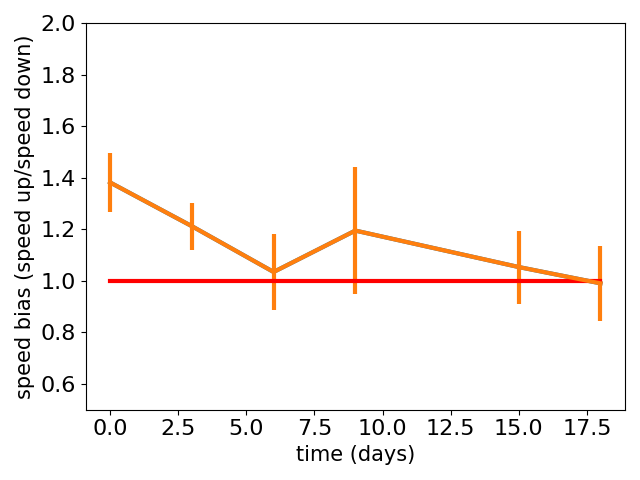

In [35]:
fig, ax = plt.subplots()
table["bias"] = -table["speed+"] / table["speed-"]
table["bias"] = table["bias"].replace(np.inf, 1)
table["bias"] = table["bias"].replace(-np.inf, 1)
select = table.loc[table["bias"] < 5]
# ax.scatter(select['3days'],select['bias'],alpha =0.1)
ax.set_ylim(0.5, 2)
mean = select.groupby("3days")["bias"].median()
std = select.groupby("3days")["bias"].std()
count = select.groupby("3days")["bias"].count()
ax.plot(mean.index * 3, mean)
ax.errorbar(mean.index * 3, mean, 2 * std / np.sqrt(count))
ax.set_xlabel("time (days)")
ax.set_ylabel("speed bias (speed up/speed down)")
ax.plot(mean.index * 3, 1 + mean.index * 0, color="red")

plt.tight_layout()

In [91]:
# fig,ax = plt.subplots()
# table['bias']=-table['speed+']/table['speed-']
# table['bias'] = table['bias'].replace(np.inf,1)
# table['bias'] = table['bias'].replace(-np.inf,1)
# select = table.loc[table['bias']<5]
# # ax.scatter(select['3days'],select['bias'],alpha =0.1)
# ax.set_ylim(0.5,2)
# mean = select.groupby('speed')["bias"].median()
# std = select.groupby('speed')["bias"].std()
# count = select.groupby('speed')["bias"].count()
# ax.plot(mean.index*3,mean)
# ax.errorbar(mean.index*3,mean,2*std/np.sqrt(count))
# ax.set_xlabel('time (days)')
# ax.set_ylabel('speed bias (speed up/speed down)')
# ax.plot(mean.index*3,1+mean.index*0,color='red')

# plt.tight_layout()

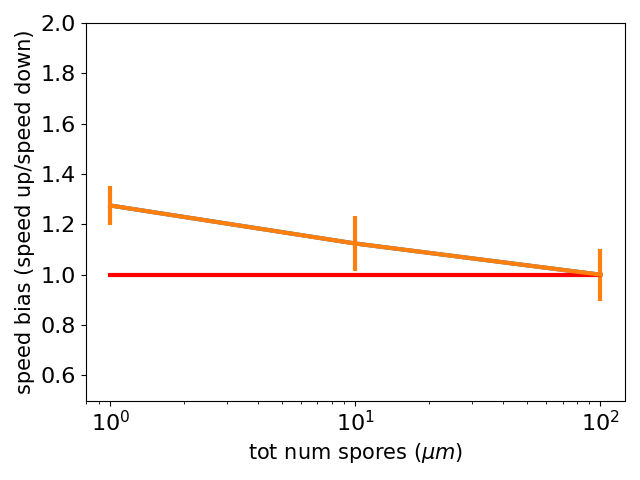

In [55]:
fig, ax = plt.subplots()
table["bias"] = -table["speed+"] / table["speed-"]
table["bias"] = table["bias"].replace(np.inf, 1)
table["bias"] = table["bias"].replace(-np.inf, 1)
select = table.loc[table["bias"] < 5]
# ax.scatter(select['3days'],select['bias'],alpha =0.1)
ax.set_ylim(0.5, 2)
mean = select.groupby("log_tot_num_spores")["bias"].median()
std = select.groupby("log_tot_num_spores")["bias"].std()
count = select.groupby("log_tot_num_spores")["bias"].count()
ax.plot(10**mean.index, mean)
ax.errorbar(10**mean.index, mean, 2 * std / np.sqrt(count))
ax.set_xlabel("tot num spores ($\mu m$)")
ax.set_ylabel("speed bias (speed up/speed down)")
ax.plot(10**mean.index, 1 + mean.index * 0, color="red")
ax.set_xscale("log")
plt.tight_layout()

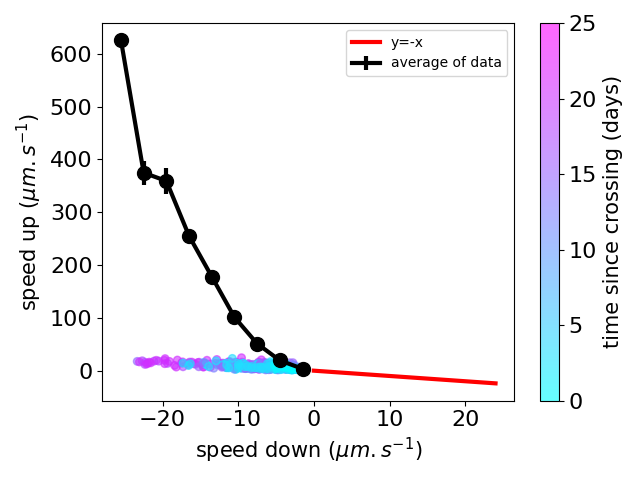

In [87]:
fig, ax = plt.subplots()
cmap = cm.get_cmap("cool", 100)

select = table.loc[table["speed+"].between(1, 25)]
select = select.loc[select["speed-"].between(-25, -1)]
max_day = 25
norm = mpl.colors.Normalize(vmin=0, vmax=max_day)

scatter = ax.scatter(
    select["speed-"],
    select["speed+"],
    c=select["days"],
    cmap="cool",
    alpha=0.6,
    norm=norm,
    s=30,
)
group_size = 3
select["speed-group"] = (select["speed"].replace(-np.inf, 0) / group_size).astype(
    int
) * group_size
group = select.groupby("speed-group")["speed+"].median()
# ax.plot(group.index,group,color='black')
std_bias = select.groupby("speed-group")["speed+"].std()
count_bias = select.groupby("speed-group")["speed+"].count()
statistic = make_stat(group.index, ax)
data = np.array((group.index, group))
n_resamples = 100
# std = scipy.stats.bootstrap(data,statistic,
#                             vectorized = False,
#                             method="basic",
#                             n_resamples = n_resamples,
#                             paired= True).standard_error
ax.scatter(
    -group.index - group_size / 2, (group.index + group_size / 2) * group, color="black"
)

ax.errorbar(
    -group.index - group_size / 2,
    (group.index + group_size / 2) * group,
    (group.index + group_size / 2) * std_bias / np.sqrt(count_bias),
    color="black",
    label="average of data",
)
ax.plot(group.index, -group.index, color="red", label="y=-x")
ax.set_xlabel("speed down ($\mu m.s^{-1}$)")
ax.set_ylabel("speed up ($\mu m.s^{-1}$)")
ax.legend()
fig.colorbar(scatter, label="time since crossing (days)", ax=ax)
plt.tight_layout()

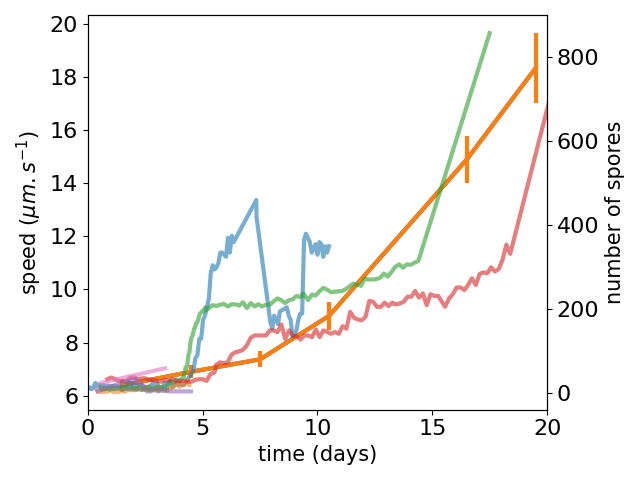

In [15]:
fig, ax = plt.subplots()
# select = table.loc[table.groupby('unique_id')['days_since_first_image'].transform('max')>0]
# select = select.loc[select['unique_id']=="803_20211012"]
select = table.loc[table["speed+"].between(1, 50)]
select = select.loc[select["speed-"].between(-50, -1)]
# ax.scatter(select['days'],select['speed'],alpha =0.1)
mean = select.groupby("3days")["speed"].mean()
std = select.groupby("3days")["speed"].std()
count = select.groupby("3days")["speed"].count()
ax.plot(3 * mean.index + 1.5, mean)
ax.errorbar(3 * mean.index + 1.5, mean, std / np.sqrt(count))
ax.set_xlabel("time (days)")
ax.set_ylabel("speed ($\mu m.s^{-1}$)")
ax2 = ax.twinx()
# ax2.scatter(table['days'],table['tot_num_spore'])
for unique_id in table["unique_id"].unique():
    select_spores = table_spores.loc[table_spores["unique_id"] == unique_id]
    average = select_spores.groupby("days")["x"].count()
    ax2.plot(average.index, average, alpha=0.6, label=unique_id)
ax.set_xlim(0, 20)
# ax2.set_yscale('log')
# ax.set_yscale('log')
ax2.set_ylabel("number of spores")
# plt.legend()
plt.tight_layout()

In [1]:
1

1

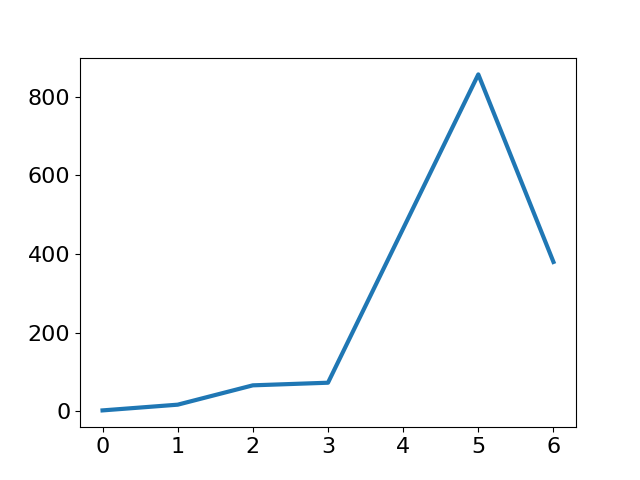

In [17]:
fig, ax = plt.subplots()
select = table.loc[table["speed+"].between(1, 50)]
select = select.loc[select["speed-"].between(-50, -1)]
# ax.scatter(select['days'],select['speed'],alpha =0.1)
mean = select.groupby("3days")["tot_num_spore"].mean()
std = select.groupby("3days")["tot_num_spore"].std()
count = select.groupby("3days")["tot_num_spore"].count()
ax.plot(mean.index, mean)
# ax.errorbar(mean.index,mean,std/np.sqrt(count))

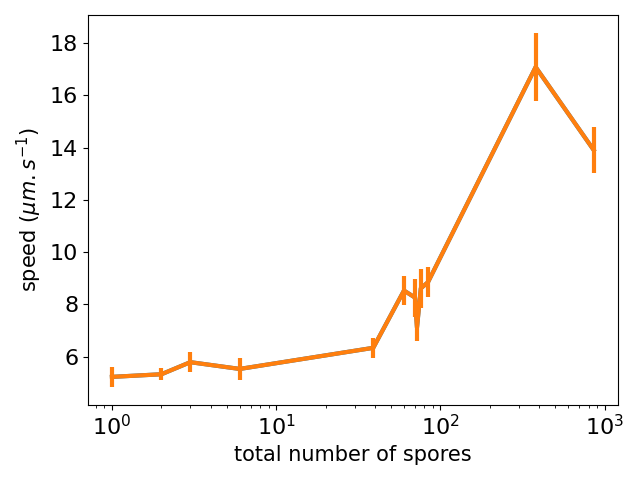

In [18]:
fig, ax = plt.subplots()
# select = table.loc[table.groupby('unique_id')['days_since_first_image'].transform('max')>0]
# select = select.loc[select['unique_id']=="803_20211012"]
select = table.loc[table["speed+"].between(1, 50)]
select = select.loc[select["speed-"].between(-50, -1)]
# ax.scatter(select['tot_num_spore'],select['speed'],alpha =0.1)
mean = select.groupby("tot_num_spore")["speed"].median()
percentile = select.groupby("tot_num_spore")["speed"].quantile(0.9)

std = select.groupby("tot_num_spore")["speed"].std()
count = select.groupby("tot_num_spore")["speed"].count()
ax.plot(mean.index, mean)
# ax.plot(mean.index,percentile,color="red")

ax.errorbar(mean.index, mean, std / np.sqrt(count))
ax.set_xlabel("total number of spores")
ax.set_ylabel("speed ($\mu m.s^{-1}$)")
# ax.set_ylim(0,50)
ax.set_xscale("log")
# ax.set_yscale('log')

plt.tight_layout()

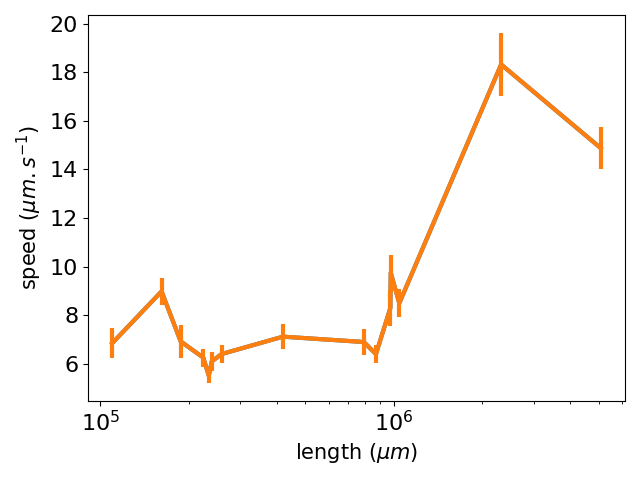

In [102]:
fig, ax = plt.subplots()
# select = table.loc[table.groupby('unique_id')['days_since_first_image'].transform('max')>0]
# select = select.loc[select['unique_id']=="803_20211012"]
select = table.loc[table["speed+"].between(1, 50)]
select = select.loc[select["speed-"].between(-50, -1)]
# ax.scatter(select['tot_length'],select['speed'],alpha =0.1)
mean = select.groupby("tot_length")["speed"].mean()
std = select.groupby("tot_length")["speed"].std()
count = select.groupby("tot_length")["speed"].count()
ax.plot(mean.index, mean)
ax.errorbar(mean.index, mean, std / np.sqrt(count))
ax.set_xlabel("length ($\mu m$)")
ax.set_ylabel("speed ($\mu m.s^{-1}$)")
# ax.set_ylim(0,20)
ax.set_xscale("log")
# ax.set_yscale('log')

plt.tight_layout()

In [95]:
import statsmodels.api as sm

X = select[["tot_num_spore"]]
y = select["speed"]
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     206.4
Date:                Mon, 27 Feb 2023   Prob (F-statistic):           1.38e-40
Time:                        16:36:43   Log-Likelihood:                -1959.4
No. Observations:                 619   AIC:                             3923.
Df Residuals:                     617   BIC:                             3932.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             7.2422      0.266     27.229      0.000       6.720       7.765
tot_num_spore     0.0130      0.001     14.367      0.000       0.011       0.015
==============================================================================
Omnibus:                      330.563   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2680.951
Skew:                           2.252   Prob(JB):                         0.00
Kurtosis:                      12.147   Cond. No.                         340.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
X = select[["tot_num_spore"]]
y = select["speed"]
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

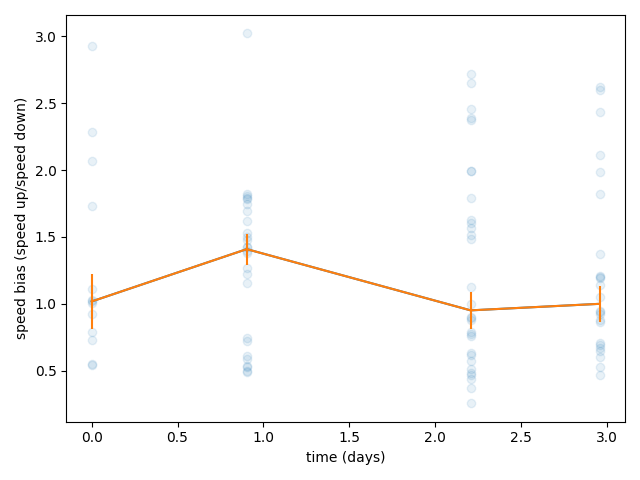

In [52]:
fig, ax = plt.subplots()
select = table.loc[
    table.groupby("unique_id")["days_since_first_image"].transform("max") > 0
]
select = select.loc[select["unique_id"] == "809_20211012"]
ax.scatter(select["days_since_first_image"], select["bias"], alpha=0.1)
mean = select.groupby("days_since_first_image")["bias"].median()
std = select.groupby("days_since_first_image")["bias"].std()
count = select.groupby("days_since_first_image")["bias"].count()
ax.plot(mean.index, mean)
ax.errorbar(mean.index, mean, std / np.sqrt(count))
ax.set_xlabel("time (days)")
ax.set_ylabel("speed bias (speed up/speed down)")
plt.tight_layout()

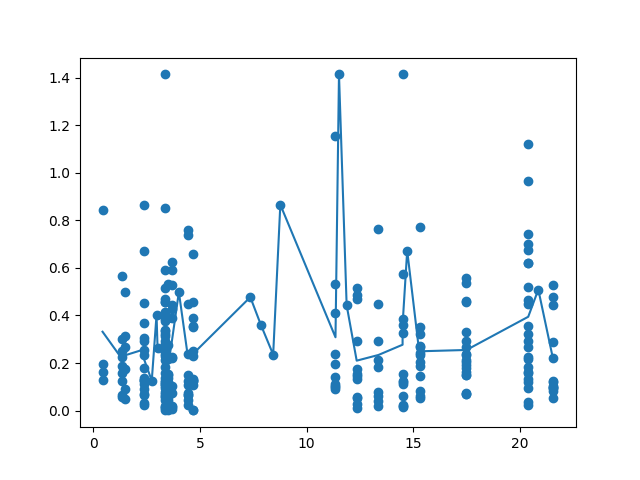

In [8]:
fig, ax = plt.subplots()
std = table.groupby(["posy"])["speed+"].std()
mean = table.groupby(["posy"])["speed+"].mean()
count = table.groupby(["posy"])["speed+"].count()
days_columns = table.groupby(["posy"])["days"].mean()
grouping = 3
column = (mean / grouping).astype(int) * grouping
dataf = pd.DataFrame(mean)
dataf["speed_int"] = column
dataf["days"] = days_columns

dataf["CV"] = std / mean

average = dataf.groupby("days")["CV"].mean()
ax.scatter(days_columns, std / mean)
ax.plot(average.index, average)

KeyError: 'tot_num_spore'

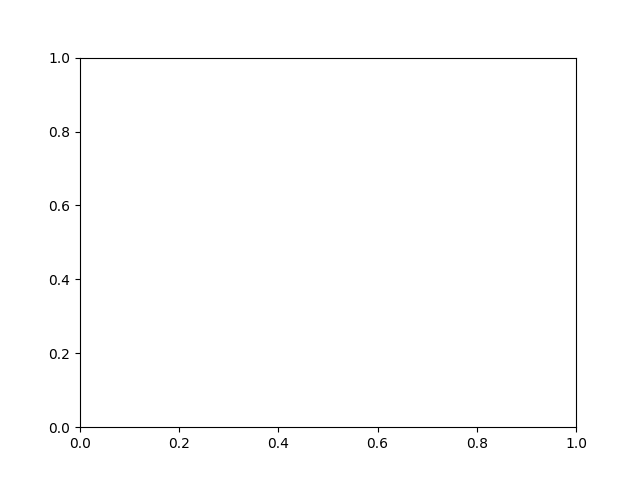

In [9]:
fig, ax = plt.subplots()
ax.scatter(table["tot_num_spore"], table[f"speed"], alpha=0.1)
group = table.groupby("tot_num_spore")["speed"].median()
ax.plot(group.index, group)
group_error = table.groupby("tot_num_spore")["speed"].std()
group_count = table.groupby("tot_num_spore")["speed"].count()

ax.errorbar(group.index, group, group_error / np.sqrt(group_count))
ax.set_xlabel("number of spores")
ax.set_ylabel("max speed ($\mu m.s^{-1}$)")
ax.set_yscale("log")
ax.set_ylim(2, 100)
plt.tight_layout()

In [14]:
column = table["speed+"] + table["speed-"]
column = column.replace(np.inf, 0)
column = column.replace(-np.inf, 0)

np.mean(column), np.std(column) / np.sqrt(len(column))

(-0.05448060903426778, 0.536651903223975)

In [47]:
def make_stat(x0, ax):
    def statistic(x, y):
        # X = sm.add_constant(x, prepend=False)
        X = x
        model = sm.OLS(y, X)
        res = model.fit()
        a = res.params[0]
        ax.plot(x0, np.array(x0) * a, color="grey", alpha=0.01)
        return a

    return statistic

(array([ 48., 229., 157.,  71.,  55.,  38.,  18.,   9.,   3.,   6.,   4.,
          3.,   3.,   2.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([ 0.     ,  2.71685,  5.4337 ,  8.15055, 10.8674 , 13.58425,
        16.3011 , 19.01795, 21.7348 , 24.45165, 27.1685 , 29.88535,
        32.6022 , 35.31905, 38.0359 , 40.75275, 43.4696 , 46.18645,
        48.9033 , 51.62015, 54.337  ]),
 <BarContainer object of 20 artists>)

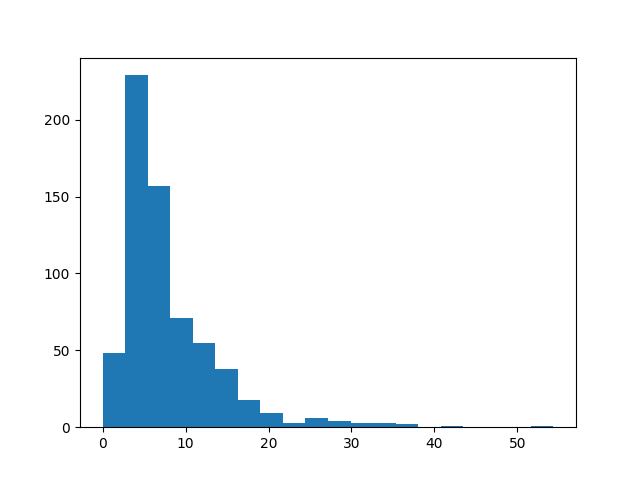

In [53]:
fig, ax = plt.subplots()
ax.hist(table["speed+"], 20)

In [10]:
# grouping_window_mult = 13
# table['group_density'] = (table[f"spore_density_{size}"]*grouping_window_mult).astype(int)
size = 1000
table["group_density"] = table[f"spore_density_num_{size}"]
speedp = table.groupby("group_density")["speed+"].median()
speedm = table.groupby("group_density")["speed-"].median()
speedp_error = table.groupby("group_density")["speed+"].std()
speedp_count = table.groupby("group_density")["speed+"].count()

speedm = table.groupby("group_density")["speed-"].median()
speedm_error = table.groupby("group_density")["speed-"].std()
speedm_count = table.groupby("group_density")["speed-"].count()

# space_pixel_size = 1.725
speedp.index

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype='int64', name='group_density')

Text(0, 0.5, 'maximum speeds ($\\mu m.s^{-1}$)')

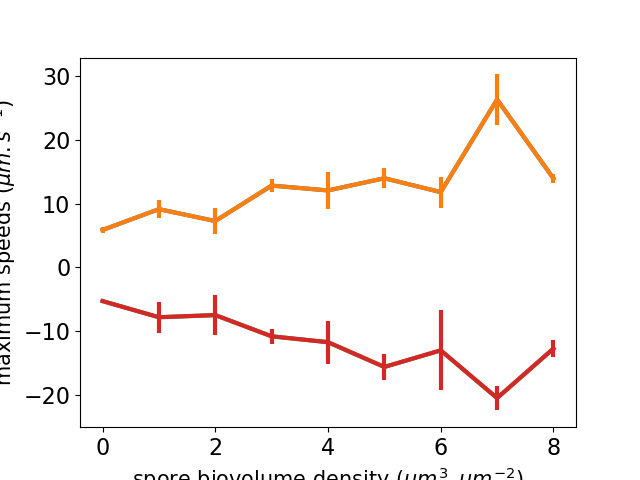

In [11]:
fig, ax = plt.subplots()
# ax.scatter(table["group_density"]/grouping_window_mult/space_pixel_size**2,table['speed-'])
ax.plot(speedp.index, speedp)
ax.errorbar(speedp.index, speedp, speedp_error / np.sqrt(speedp_count))
ax.plot(speedp.index, speedm)
ax.errorbar(speedp.index, speedm, speedm_error / np.sqrt(speedm_count))
ax.set_xlabel("spore biovolume density ($\mu m^{3}.\mu m^{-2}$)")
ax.set_ylabel("maximum speeds ($\mu m.s^{-1}$)")

In [72]:
table["speed"]

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
      ..
25   NaN
26   NaN
27   NaN
28   NaN
29   NaN
Name: speed, Length: 260, dtype: float64

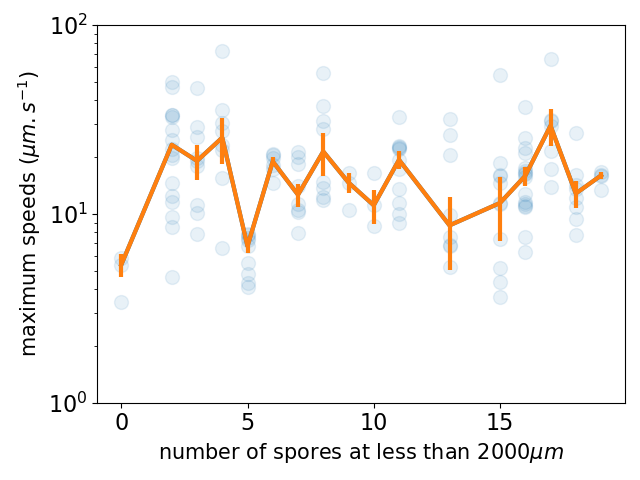

In [12]:
size = 2000
table["group_density"] = table[f"spore_density_num_{size}"]
table["abs_speed-"] = -table["speed-"]
table["speed"] = table[["speed+", "abs_speed-"]].max(1)
select = table.loc[table["tot_num_spore"] >= 200]
speed = select.groupby("group_density")["speed"].median()
speed_error = select.groupby("group_density")["speed"].std()
speed_count = select.groupby("group_density")["speed"].count()
fig, ax = plt.subplots()
ax.scatter(select[f"spore_density_num_{size}"], select[f"speed"], alpha=0.1)

# ax.scatter(table["group_density"]/grouping_window_mult/space_pixel_size**2,table['speed-'])
ax.plot(speed.index, speed)
ax.errorbar(speed.index, speed, speed_error / np.sqrt(speed_count))
# ax.plot(speedp.index,speedm)
# ax.errorbar(speedp.index,speedm,speedm_error/np.sqrt(speedm_count))
ax.set_xlabel(f"number of spores at less than {size}$\mu m$")
ax.set_ylabel("maximum speeds ($\mu m.s^{-1}$)")
ax.set_yscale("log")
ax.set_ylim(1, 100)
plt.tight_layout()